![Alt text](./figures/logo.png)

source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! The data is available in csv-Format as `penguins.csv`

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

Column | Description
--- | ---
culmen_length_mm | culmen length (mm)
culmen_depth_mm | culmen depth (mm)
flipper_length_mm | flipper length (mm)
body_mass_g | body mass (g)
sex | penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are **at least three** species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**.  Your task is to apply your data science skills to help them identify groups in the dataset!

In [1]:
# Import Required Packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import seaborn as sns
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")


## Reading the CSV file

First lets read the CSV file.

In [2]:
# Loading and examining the dataset
penguins_df = pd.read_csv("./data/penguins.csv")
penguins_df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,36.7,19.3,193.0,3450.0,FEMALE
4,39.3,20.6,190.0,3650.0,MALE


## Cleaning Data

The uploaded dataset will be assessed to evaluate its quality and ensure it is suitable for analysis. This includes checking for missing values, identifying outliers, and verifying data types and consistency.


In [3]:
df = penguins_df  # Assign a shorter, more convenient variable name for easier handling

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    float64
 3   body_mass_g        332 non-null    float64
 4   sex                332 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.1+ KB


In [5]:
df['sex'].unique()

array(['MALE', 'FEMALE'], dtype=object)

In [6]:
df['sex']=df['sex'].astype('category')

In [7]:
df.describe(include='category')

,sex
count,332
unique,2
top,MALE
freq,167


In [8]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,332.000000,332.000000,332.000000,332.000000
mean,44.021084,17.153012,200.975904,4206.475904
std,5.452462,1.960275,14.035971,806.361278
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.700000,17.300000,197.000000,4025.000000
75%,48.625000,18.700000,213.000000,4781.250000
max,59.600000,21.500000,231.000000,6300.000000


- Created a shorter alias `'df'` for the original DataFrame `'penguins_df'` to simplify references.
- Ensured that only non-empty (non-null) rows are considered.
- The `'sex'` column contains only two unique categories: `'MALE'` and `'FEMALE'`.
- Converted the data type of the `'sex'` column to `'category'` for optimised storage and performance.
- No outliers were identified.


## Preliminary Analysis

To begin the exploratory analysis, a pair plot was generated to visualise the relationships between numerical features in the dataset.

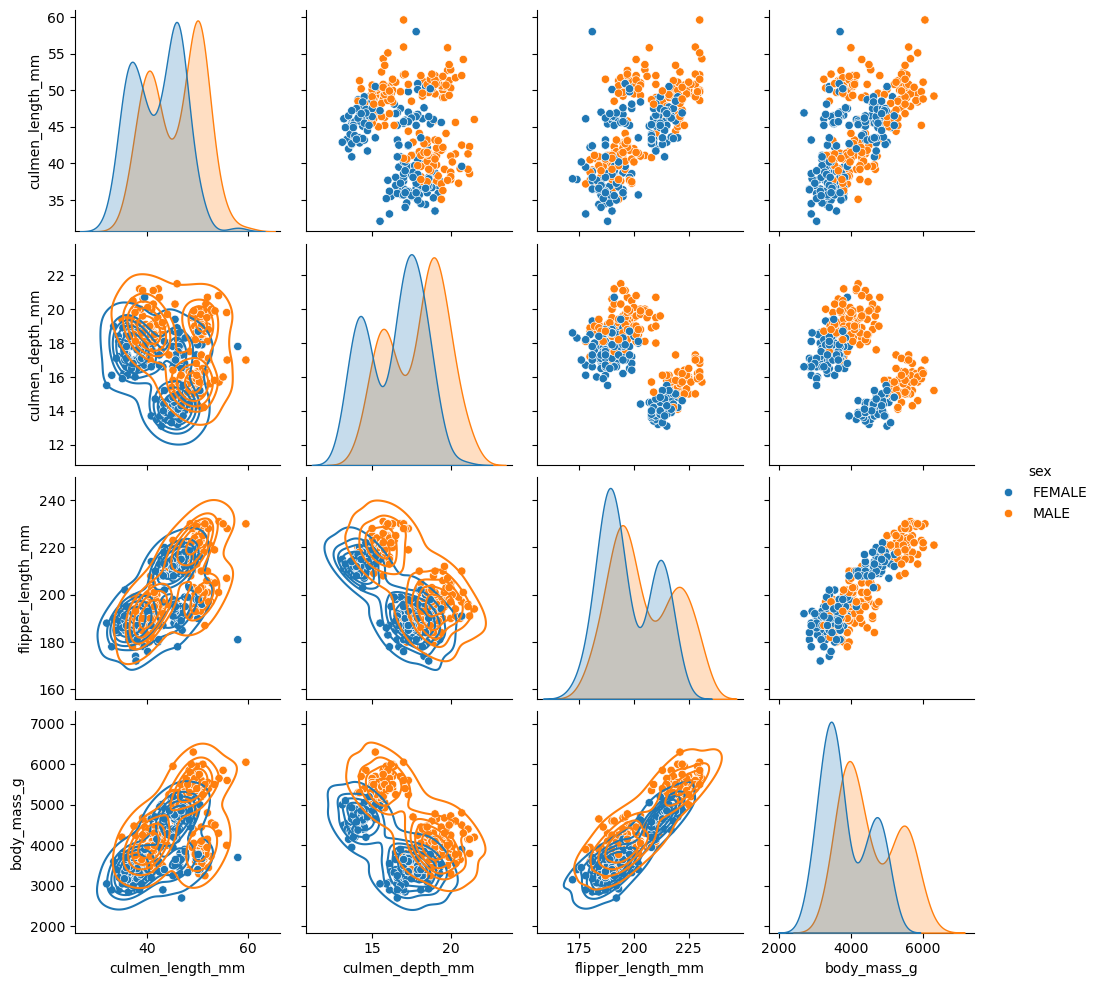

In [9]:
g = sns.pairplot(df, hue='sex')
g.map_lower(sns.kdeplot, levels=6, color="green")
plt.savefig('./plots/pairplot.png')
plt.show()

### Initial Insights

- The data can be categorised into two groups — `'MALE'` and `'FEMALE'` — and has been colour-coded accordingly in the plot.
- Preliminary observations indicate that **male** individuals tend to have **larger body dimensions and greater weight**.
- The pair plot also reveals visual groupings, suggesting the presence of three distinct clusters within the data — a promising sign for uncovering the underlying species.
- The distributions of the four numerical features appear to be **bimodal**. While this might initially suggest the presence of only two species, the clustering into three distinct groups supports the hypothesis of three separate species.


## Clustering

### Dummy Variable Encoding

To prepare the data for clustering, the `'sex'` column is converted into binary variables using `pd.get_dummies`. This process creates two new columns: `'sex_MALE'` and `'sex_FEMALE'`, each indicating the presence of a specific category with a value of `1.0`. For example, if a row originally had `'MALE'` in the `'sex'` column, the `'sex_MALE'` column will contain `1.0` and `'sex_FEMALE'` will contain `0.0`.

Encoding categorical variables in this way ensures that all features are numerical, making the dataset compatible with `scikit-learn` clustering algorithms such as K-Means.


In [10]:
df = pd.get_dummies(df,drop_first=True, dtype='float')
display(df.head())


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
0,39.1,18.7,181.0,3750.0,1.0
1,39.5,17.4,186.0,3800.0,0.0
2,40.3,18.0,195.0,3250.0,0.0
3,36.7,19.3,193.0,3450.0,0.0
4,39.3,20.6,190.0,3650.0,1.0


### Standardising the Dataset and Determining Optimal Clusters

Before applying clustering algorithms, all numerical features in the dataset are standardised using `StandardScaler` from `scikit-learn`. Standardisation transforms the data so that each feature has a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to distance calculations during clustering, preventing features with larger scales from dominating the results.


In [11]:
scaler = StandardScaler()
samples = scaler.fit_transform(df)

### Elbow Analysis Procedure

The `KMeans` clustering algorithm is applied to the standardised data to explore different clustering configurations. A loop is used to iterate over a range of cluster counts (`k` values from 1 to 10). For each value of `k`, the algorithm is fit to the data.

After fitting, the **inertia** — a measure of how tightly the data points are grouped within each cluster — is recorded. Lower inertia indicates more compact clusters.

Once all inertia values are collected, they are plotted against their corresponding `k` values to generate an **elbow plot**. This visualisation helps identify the optimal number of clusters by locating the "elbow" point — where adding more clusters yields diminishing returns in reducing inertia.


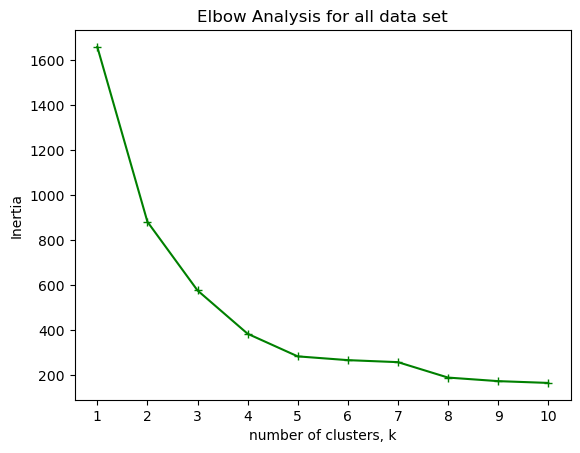

In [12]:
ks = range(1, 11)
inertias_all = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=69)
    kmeans.fit(samples)    # Fit model to samples    
    inertias_all.append(kmeans.inertia_) # Append the inertia to the list of inertias
    
# Plot ks vs inertias
plt.plot(ks, inertias_all, '-+', color='green')
plt.title('Elbow Analysis for all data set')
plt.xlabel('number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.savefig('./plots/elbow_test_all.png', format='png')
plt.show()

### Interpretation of Elbow Analysis

The elbow plot shows a steep decline in inertia followed by a more gradual reduction as `k` increases, with the curve beginning to flatten around **`k = 5` or `k = 6`**. This suggests that beyond this point, additional clusters offer limited improvement in compactness.

This pattern indicates that **five or six clusters** may provide a suitable segmentation of the dataset. These clusters may reflect underlying substructures in the data, such as biological variation or latent groupings not explicitly represented by existing features.

Interestingly, there is also a smaller inflection point observed between **`k = 7` and `k = 8`**, which may suggest the presence of an additional subtle grouping. This could indicate that the data contains more complexity than initially assumed — potentially even hinting at the existence of a **fourth species** or additional variation within known categories.

Selecting an appropriate `k` based on this analysis helps ensure meaningful and interpretable clustering results, balancing model complexity with explanatory power.


## Clustering Analysis with **k = 5** Clusters

Based on the results of the elbow analysis, `k = 5` has been selected as the number of clusters for further exploration. This value represents a balance between model complexity and interpretability, capturing potential underlying structures in the data without overfitting.

In this step, the `KMeans` algorithm is applied to the standardised dataset using `k = 5` clusters. After fitting the model, the resulting cluster labels are assigned to each observation and added to the dataset for further analysis.

This clustering outcome will now serve as the foundation for visual exploration and interpretation of group characteristics.


In [13]:
# Run KMeans with the optimal number of clusters
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters,  random_state=69)
kmeans.fit(samples)

labels = kmeans.labels_ # Get cluster labels and add it to the dataframe
df['label'] = labels
display(df.sample(10))

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex_MALE,label
159,45.9,17.1,190.0,3575.0,0.0,2
67,35.5,17.5,190.0,3700.0,0.0,2
75,36.7,18.8,187.0,3800.0,0.0,2
166,48.5,17.5,191.0,3400.0,1.0,4
270,43.2,14.5,208.0,4450.0,0.0,3
20,40.6,18.6,183.0,3550.0,1.0,0
35,40.8,18.4,195.0,3900.0,1.0,0
324,46.2,14.1,217.0,4375.0,0.0,3
171,50.5,18.4,200.0,3400.0,0.0,4
145,46.5,17.9,192.0,3500.0,0.0,2


### Visualising Cluster Distributions by Feature

With cluster labels now assigned, we can explore how each numerical feature is distributed across the identified clusters. Visualising these relationships helps reveal patterns and distinctions between groups, offering insight into how the clustering algorithm segmented the data.

The following scatter plots display each feature plotted against cluster labels, allowing us to examine how different biological measurements contribute to the separation between clusters.


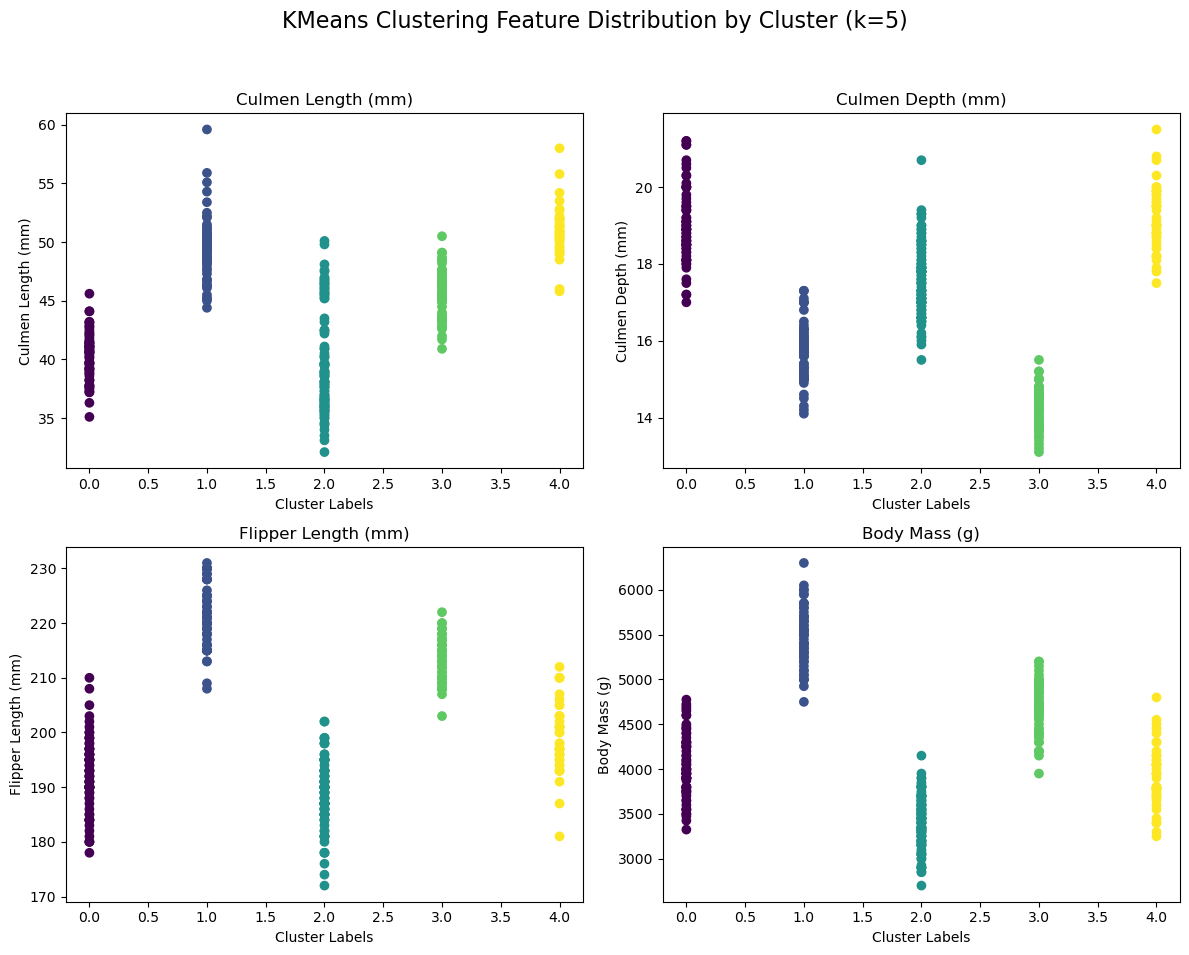

In [14]:
# Set up a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle(f'KMeans Clustering Feature Distribution by Cluster (k={n_clusters})', fontsize=16)

# Plot 1: Culmen Length
axs[0, 0].scatter(df['label'], df['culmen_length_mm'], c=df['label'])
axs[0, 0].set_title('Culmen Length (mm)')
axs[0, 0].set_xlabel('Cluster Labels')
axs[0, 0].set_ylabel('Culmen Length (mm)')

# Plot 2: Culmen Depth
axs[0, 1].scatter(df['label'], df['culmen_depth_mm'], c=df['label'])
axs[0, 1].set_title('Culmen Depth (mm)')
axs[0, 1].set_xlabel('Cluster Labels')
axs[0, 1].set_ylabel('Culmen Depth (mm)')

# Plot 3: Flipper Length
axs[1, 0].scatter(df['label'], df['flipper_length_mm'], c=df['label'])
axs[1, 0].set_title('Flipper Length (mm)')
axs[1, 0].set_xlabel('Cluster Labels')
axs[1, 0].set_ylabel('Flipper Length (mm)')

# Plot 4: Body Mass
axs[1, 1].scatter(df['label'], df['body_mass_g'], c=df['label'])
axs[1, 1].set_title('Body Mass (g)')
axs[1, 1].set_xlabel('Cluster Labels')
axs[1, 1].set_ylabel('Body Mass (g)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('./plots/matrix_feat_labels.png', format='png')
plt.show()


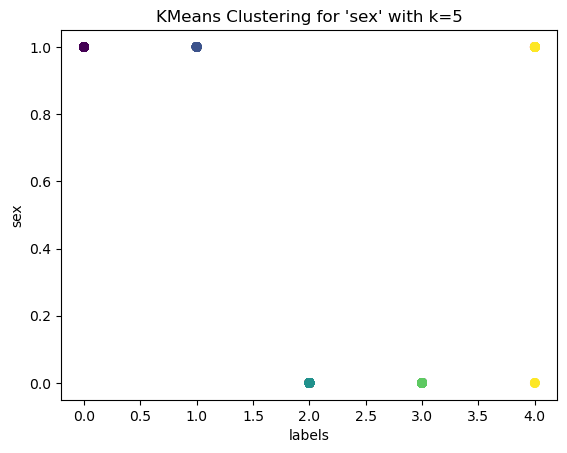

In [15]:
plt.scatter(df['label'], df['sex_MALE'],c=df['label'])
plt.xlabel('labels')
plt.ylabel('sex')
plt.title(f"KMeans Clustering for 'sex' with k={n_clusters}")
plt.savefig('./plots/label_sex_k5.png', format='png')
plt.show()

## Final solution

In [18]:
numeric_columns = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm','label']
stat_penguins = df[numeric_columns].groupby('label').mean()
display(stat_penguins)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm
label,,,
0,40.315714,19.011429,192.242857
1,49.473770,15.718033,221.540984
2,39.744660,17.588350,188.864078
3,45.563793,14.237931,212.706897
4,50.965000,19.195000,199.075000


## 🐧 Plot Twist!!!

When plotting the `sex_MALE` column alongside the cluster labels, something unexpected shows up — in **Cluster 4**, both males  and females  appear! 🤯

This suggests a surprising overlap, possibly caused by **small males** from one species clustering together with **larger females** from another. Could it be that we overlooked the third penguin species in our earlier assumptions? ♂️🐧♀️

Curious about this anomaly, I ran the clustering again using `k = 6` (maybe the mix would disappear?) — but nope, the overlap persisted. Tried `k = 7`? Still there. It wasn’t until I reached **`k = 8`** that the clusters finally started to separate more clearly by sex — just like that subtle inflection in the elbow plot had suggested all along! 👀

So now we have to wonder — is this a hint at an **undiscovered penguin species**? Or just a fascinating case of biological variation and overlap? 🧬

Of course, we can’t rule out the possibility of a **statistical quirk**, especially given the limitations of small sample sizes. Sometimes clusters can behave unexpectedly when data is sparse or unevenly distributed.

Either way, things are getting interesting. It’s like two penguin worlds colliding! 🐧💥🐧

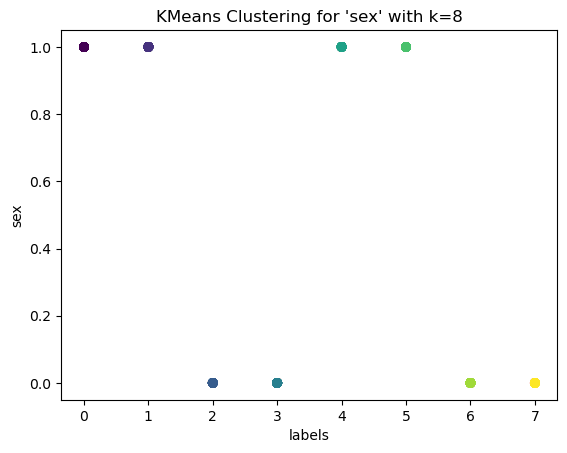

In [16]:
# Run KMeans with the optimal number of clusters
n_clusters_pt = 8
kmeans = KMeans(n_clusters=n_clusters_pt,  random_state=69)
kmeans.fit(samples)

labels = kmeans.labels_ # Get cluster labels and add it to the dataframe
df_pt = df.copy()
df_pt['label'] = labels

plt.scatter(df_pt['label'], df_pt['sex_MALE'],c=df_pt['label'])
plt.xlabel('labels')
plt.ylabel('sex')
plt.title(f"KMeans Clustering for 'sex' with k={n_clusters_pt}")
plt.savefig('./plots/label_sex_k8.png', format='png')
plt.show()